# Learning 3D SDF

In [1]:
%matplotlib inline

# import libraries
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import torch

import trimesh
from mesh_to_sdf import sample_sdf_near_surface
from utils import calculateSurf, visualize, writeOBJ, fillSDF
from networks import Feedforward, HarmonicEmbedding, FeedforwardNeRF, FeedforwardSIREN
from train import train

## Hyper parameter intialization

In [2]:
W = 64  #width
H = 64  #height
D = 64  #depth
R = 16  #radius
iso_val = 0.0 #surface level
space_sampling = 0.01 # SDF sampling
number_of_points = 1000000 #SDF num points

# Might needed to be tuned per model
Hidden = 64  # hidden layer size for the models
epoch = 20000  # epoch counts
Harmonics = 32  # for postional encoding
LR = 0.01  # learning rate
SAMPLING = 1  # sampling ratio
print_rate = 5000  # printing rate # epochs
criterion = torch.nn.HuberLoss() #loss function

## Create the SDF volume, and Training data to memorize

In [3]:
SDF = np.zeros((D, H, W))
cx = W / 2
cy = H / 2
cz = D / 2
X_train = np.zeros((W * H * D, 3))
y_train = np.zeros((W * H * D))
#read mesh and convert to SDF
mesh = trimesh.load('data/teddy.obj')
points, sdf = sample_sdf_near_surface(mesh, number_of_points)
points = (points + 1) * W / 2 #points are between 0->W

In [4]:
## Calculate SDF using sampled points and surface using marching cubes

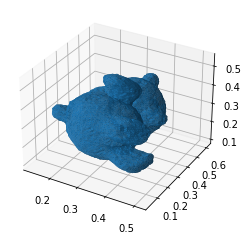

	 Exporting SDF.obj (8945 verts , 17886 tris)


In [5]:
tree = KDTree(points)
count = 0
SDF = np.zeros((D, H, W))
for k in range(D):
    for j in range(H):
        for i in range(W):
            distances, indices = tree.query(np.array((i, j, k)).reshape(1, -1), 1)
            SDF[k][j][i] = sdf[indices[0]] * W / 2
            X_train[count] = np.array(((i - cx), (j - cy), (k - cz)))
            y_train[count] = SDF[k][j][i]
            count = count + 1
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
test_list = np.random.choice(W * H * D, int(SAMPLING * W * H * D))
X_test = X_train[test_list]
y_test = y_train[test_list]
v, t, n, val = visualize(SDF)
writeOBJ("SDF.obj",v,t)
np.save("SDF_1M.npy", SDF)
np.save("points_1M.npy", points)
np.save("sdf_1M.npy", sdf)

In [6]:
# MLP SURFACE training

Epoch 0: train loss: 8.977386474609375
Epoch 5000: train loss: 0.13143688440322876
Epoch 10000: train loss: 0.10825222730636597
Epoch 15000: train loss: 0.09912519156932831


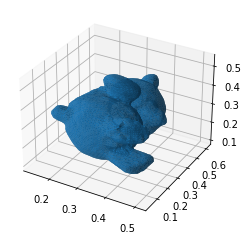

	 Exporting SDFmlp.obj (8572 verts , 17140 tris)


In [7]:
modelMLP = Feedforward(3, Hidden, Harmonics).cuda()
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=LR) #optimizer
modelMLP = train(modelMLP.cuda(), X_train.cuda(), y_train.cuda(), epoch, optimizer, criterion, print_rate, D, H, W )
SDFmlp = fillSDF(modelMLP(X_train.cuda()),D,H,W)
v, t, n, val = visualize(SDFmlp)
writeOBJ("SDFmlp.obj",v,t,-1)

In [8]:
# NERF SURFACE training

Epoch 0: train loss: 9.092611312866211
Not valid isosurface: min-max-> tensor([0.0177], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([0.1416], device='cuda:0', grad_fn=<UnbindBackward0>)
Epoch 5000: train loss: 0.11986131966114044
Epoch 10000: train loss: 0.08013620972633362
Epoch 15000: train loss: 0.0842202752828598


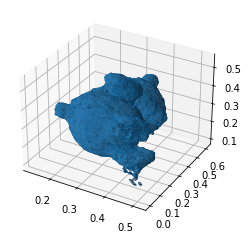

	 Exporting SDFnerf.obj (10258 verts , 20460 tris)


In [9]:
modelNeRF = FeedforwardNeRF(Harmonics, 3, Hidden).cuda()
optimizer = torch.optim.Adam(modelNeRF.parameters(), lr=LR) #optimizer
modelNeRF = train(modelNeRF.cuda(),X_train.cuda(), y_train.cuda(), epoch, optimizer, criterion, print_rate, D, H, W)
SDFnerf = fillSDF(modelNeRF(X_train.cuda()),D,H,W)
v, t, n, val = visualize(SDFnerf)
writeOBJ("SDFnerf.obj",v,t,-2)

In [10]:
# SIREN SURFACE training

Epoch 0: train loss: 9.253931045532227
Epoch 5000: train loss: 0.08605959266424179
Epoch 10000: train loss: 0.0740552470088005
Epoch 15000: train loss: 0.08256706595420837


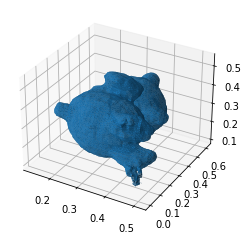

	 Exporting SDFsiren.obj (9494 verts , 18960 tris)


In [11]:
modelSIREN = FeedforwardSIREN(Harmonics, 3, Hidden).cuda()
optimizer = torch.optim.Adam(modelSIREN.parameters(), lr=LR) #optimizer
modelSIREN = train(modelSIREN.cuda(), X_train.cuda(), y_train.cuda(), epoch, optimizer, criterion, print_rate, D, H, W)
SDFsiren = fillSDF(modelSIREN(X_train.cuda()),D,H,W)
v, t, n, val = visualize(SDFsiren)
writeOBJ("SDFsiren.obj",v,t,-3)